<a href="https://colab.research.google.com/github/flobotics/colab/blob/master/tf2_ganimorph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/alpha/tutorials/generative/pix2pix

https://www.tensorflow.org/alpha/tutorials/generative/dcgan

https://www.tensorflow.org/alpha/tutorials/load_data/images#load_and_format_the_images

https://www.tensorflow.org/guide/performance/datasets

@inproceedings{Gokaslan2018,
  title={Improving Shape Deformation in Unsupervised Image to Image Translation},
  author={Aaron Gokaslan and Vivek Ramanujan and Daniel Ritchie and Kwang In Kim and James Tompkin},
  booktitle={European Conference on Computer Vision},
  year={2018}
}

https://github.com/brownvc/ganimorph

In [308]:
!pip3 install tensorflow-gpu==2.0.0-alpha0

In [309]:
!pip3 install tensorflow-addons

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

#from tensorpack import *
#from tensorpack.utils.viz import *
import tensorflow as tf

import numpy as np

import time
#from tensorpack import (FeedfreeTrainerBase, QueueInput,
#                        ModelDesc, DataFlow, StagingInputWrapper,
#                        MultiGPUTrainerBase, LeastLoadedDeviceSetter)
#from tensorpack.tfutils.summary import add_moving_summary

from tensorflow.python.training import moving_averages


#import tensorpack.tfutils.symbolic_functions as symbf

import cv2
import os, sys
import argparse
from six.moves import map, zip
from glob import glob

import shutil

import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow.keras import layers

#from tensorpack import *
import tensorflow_addons as tfa

import pathlib
import random

import IPython.display as display



In [0]:
#tf.executing_eagerly()

# Input pipeline

In [312]:
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [0]:
#!mkdir /content/log
#!cp -a /content/gdrive/My\ Drive/images/model-11/* /content/log/

# Copy train and test data from e.g. Google-Drive to colab-notebook-machine

In [0]:
!mkdir -p /content/data/


!cp -a /content/gdrive/My\ Drive/images/new-images/trainA.tar.gz /content/data/
!tar -xzf /content/data/trainA.tar.gz -C /content/data/

!cp -a /content/gdrive/My\ Drive/images/new-images/trainB.tar.gz /content/data/
!tar -xzf /content/data/trainB.tar.gz -C /content/data/

!cp -a /content/gdrive/My\ Drive/images/new-images/testA.tar.gz /content/data/
!tar -xzf /content/data/testA.tar.gz -C /content/data/

!cp -a /content/gdrive/My\ Drive/images/new-images/testB.tar.gz /content/data/
!tar -xzf /content/data/testB.tar.gz -C /content/data/

!rm /content/data/testA.tar.gz
!rm /content/data/testB.tar.gz
!rm /content/data/trainA.tar.gz
!rm /content/data/trainB.tar.gz


In [0]:
SHAPE = 128
#BATCH = 16
TEST_BATCH = 32
NF = 64  # channel size

BATCH_SIZE  = 1
#FLAGS.batch_size = BATCH
#FLAGS.prefetch_buffer_size = BATCH

In [0]:
def load_and_preprocess_image(path):
  print_debug = 1
  
  image = tf.io.read_file(path)
  
  image = tf.image.decode_jpeg(image, channels=3)
  if print_debug: print("original image-shape:{}".format(image.shape))
  if print_debug: print("original image-dtype:{}".format(image.dtype))
  
  image = tf.image.resize(image, [SHAPE, SHAPE])
  image /= 255.0  # normalize to [0,1] range
  image = tf.transpose(image, perm=[2, 0, 1]) #seemed to break something, transpose ZipDataset

  if print_debug: print("preprocessed image-shape:{}".format(image.shape))
  #if print_debug: print("preprocessed image-numpy-min:{}".format(image.numpy().min()))
  #if print_debug: print("preprocessed image-numpy-max:{}".format(image.numpy().max()))
  
  return image


In [0]:
def get_all_image_paths(dir):
  print_debug = 0
  
  data_root = pathlib.Path(dir)
  if print_debug: print("image-dir:{}".format(data_root))
  
  all_image_paths = list(data_root.glob('*'))
  all_image_paths = [str(path) for path in all_image_paths]
  random.shuffle(all_image_paths)

  if print_debug: print("image-count:{}".format(len(all_image_paths)))
  
  if print_debug:
    print("3 Pictures from this set")
    for n in range(3):
      image_path = random.choice(all_image_paths)
      display.display(display.Image(image_path))
    
  return all_image_paths

# Build Dataset



In [318]:
print_debug = 1

AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1000

trainA_dir = "/content/data/trainA"
trainB_dir = "/content/data/trainB"
testA_dir = "/content/data/testA"
testB_dir = "/content/data/testB"

#---Create Dataset with trainA
all_image_paths = get_all_image_paths(trainA_dir)
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds_trainA = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
if print_debug: print("Dataset shape/type:{}".format(image_ds_trainA))

#---Create Dataset with trainB
all_image_paths = get_all_image_paths(trainB_dir)
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds_trainB = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
if print_debug: print("Dataset shape/type:{}".format(image_ds_trainA))

  #--- Create ZipDataset
image_ds_trainA_B = tf.data.Dataset.zip((image_ds_trainA, image_ds_trainB))
if print_debug: print("zipDataset  shapes/types:{}".format(image_ds_trainA_B))

#---Create Dataset with testA
all_image_paths = get_all_image_paths(testA_dir)
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds_testA = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
if print_debug: print("Dataset shape/type:{}".format(image_ds_testA))

#---Create Dataset with testB
all_image_paths = get_all_image_paths(testB_dir)
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds_testB = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
if print_debug: print("Dataset shape/type:{}".format(image_ds_testB))

#--- Create ZipDataset
image_ds_testA_B = tf.data.Dataset.zip((image_ds_testA, image_ds_testB))
if print_debug: print("zipDataset  shapes/types:{}".format(image_ds_testA_B))
#print("len:{}".format(image_ds_testA_B.))

#------
# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
image_ds_trainA_B = image_ds_trainA_B.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
image_ds_trainA_B = image_ds_trainA_B.repeat()
image_ds_trainA_B = image_ds_trainA_B.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=SHUFFLE_BUFFER_SIZE))
image_ds_trainA_B = image_ds_trainA_B.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
image_ds_trainA_B = image_ds_trainA_B.prefetch(buffer_size=AUTOTUNE)
if print_debug: print("image_ds_trainA_B shape/type {}".format(image_ds_trainA_B))

#test-images ds
image_ds_testA_B = image_ds_testA_B.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
image_ds_testA_B = image_ds_testA_B.repeat()
image_ds_testA_B = image_ds_testA_B.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=SHUFFLE_BUFFER_SIZE))
image_ds_testA_B = image_ds_testA_B.batch(BATCH_SIZE)
image_ds_testA_B = image_ds_testA_B.prefetch(buffer_size=AUTOTUNE)
if print_debug: print("image_ds_testA_B shape/type {}".format(image_ds_testA_B))

  
#for input_image, target in image_ds_testA_B:
#  print("out:{} {}".format(input_image, target))

original image-shape:(None, None, 3)
original image-dtype:<dtype: 'uint8'>
preprocessed image-shape:(3, 128, 128)
Dataset shape/type:<ParallelMapDataset shapes: (3, 128, 128), types: tf.float32>
original image-shape:(None, None, 3)
original image-dtype:<dtype: 'uint8'>
preprocessed image-shape:(3, 128, 128)
Dataset shape/type:<ParallelMapDataset shapes: (3, 128, 128), types: tf.float32>
zipDataset  shapes/types:<ZipDataset shapes: ((3, 128, 128), (3, 128, 128)), types: (tf.float32, tf.float32)>
original image-shape:(None, None, 3)
original image-dtype:<dtype: 'uint8'>
preprocessed image-shape:(3, 128, 128)
Dataset shape/type:<ParallelMapDataset shapes: (3, 128, 128), types: tf.float32>
original image-shape:(None, None, 3)
original image-dtype:<dtype: 'uint8'>
preprocessed image-shape:(3, 128, 128)
Dataset shape/type:<ParallelMapDataset shapes: (3, 128, 128), types: tf.float32>
zipDataset  shapes/types:<ZipDataset shapes: ((3, 128, 128), (3, 128, 128)), types: (tf.float32, tf.float32)>


# build the generator

In [0]:
def INReLU(self,x, name=None):
  x = tfa.layers.InstanceNormalization()(x)
  x = layers.ReLU()(x)
  return x  

In [0]:
def INLReLU(x, name=None):
  x = tfa.layers.InstanceNormalization()(x)
  x = layers.ReLU()(x)
  return x  

In [0]:
def BNLReLU(x, name):
    x = BatchNorm('bn', x)
    return tf.nn.relu(x)

In [0]:
df = "channels_first"
debug_show_shapes = 0

def build_res_block(x, name, chan, first=False):
  input = x
  l = layers.Conv2D(filters=NF*2,
                    kernel_size=3,
                    strides=1,
                    padding='same',
                    data_format=df,
                    kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                    use_bias=False)(x)
  
  if debug_show_shapes: print("l: {}".format(l.shape))
  l = layers.Conv2D(filters=NF*2,
                    kernel_size=3,
                    strides=1,
                    padding='same',
                    data_format=df,
                    kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                    use_bias=False)(l)
  
  if debug_show_shapes: print("l: {}".format(l.shape))
  l = tf.concat([l, input], axis=1)
  
  if debug_show_shapes: print("l: {}".format(l.shape))
  layer1 = layers.Conv2D(filters=NF*2,
                    kernel_size=3,
                    strides=1,
                    padding='same',
                    data_format=df,
                    kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                    use_bias=False)(l)
  
  if debug_show_shapes: print("layer1: {}".format(layer1.shape))
  
  return l


def res_group(input, name, depth, channels):
  l = input
  for k in range(depth):
    l = build_res_block(l, name + ('/res%d' % k), channels,
            first=(k==0))
  return l

In [0]:
def Generator():

  debug_show_shapes = 0
  
  subDepth = 3
  df = "channels_first"

  inputs = tf.keras.Input(shape=(3, 128, 128))  # Returns a placeholder tensor
  if debug_show_shapes: print("inputs: {}".format(inputs.shape))
  
  conv0 = layers.Conv2D(filters=NF, 
                        kernel_size=4, 
                        strides=2,
                        padding='same',
                        activation=tf.nn.relu, 
                        data_format=df, 
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"), 
                        use_bias=False)(inputs)
  
  if debug_show_shapes: print("conv0: {}".format(conv0.shape))
  
  conv1 = layers.Conv2D(filters=NF*2,
                        kernel_size=4,
                        strides=2,
                        padding='same',
                        data_format=df,
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                        use_bias=False,
                        activation=INLReLU)(conv0)

  if debug_show_shapes: print("conv1: {}".format(conv1.shape))
  
  #-------------------------
  layer1 = res_group(conv1, 'layer1', subDepth, NF*2)
  
  #-----------------
  conv2 = layers.Conv2D(filters=NF*4,
                        kernel_size=4,
                        strides=2,
                        padding='same',
                        data_format=df,
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                        use_bias=False,
                        activation=INLReLU)(layer1)
  
  if debug_show_shapes: print("conv2: {}".format(conv2.shape))
  #----------------
  
  layer2 = res_group(conv2, 'layer2', subDepth, NF*4)
  
  #-----------------
  conv3 = layers.Conv2D(filters=NF*8,
                        kernel_size=4,
                        strides=2,
                        padding='same',
                        data_format=df,
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                        use_bias=False,
                        activation=INLReLU)(layer2)
  
  if debug_show_shapes: print("conv3: {}".format(conv3.shape))
  #---------------
  l = res_group(conv3, 'layer3', subDepth, NF*8)
  
  #--------------
  
  deconv0 = layers.Conv2DTranspose(filters=NF*4,
                                   kernel_size=4,
                                   strides=2,
                                   padding='same',
                                   data_format=df,
                                   kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                                   use_bias=False,
                                   activation=INLReLU)(l)
  
  if debug_show_shapes: print("deconv0: {}".format(deconv0.shape))
  #-----------------
  up1 = tf.concat([deconv0, layer2], axis=1)
  
  #------------
  b_layer_2 = res_group(up1, 'blayer2', subDepth, NF * 4)
  
  #----------
  deconv1 = layers.Conv2DTranspose(filters=NF*2,
                                   kernel_size=4,
                                   strides=2,
                                   padding='same',
                                   data_format=df,
                                   kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                                   use_bias=False,
                                   activation=INLReLU)(b_layer_2)
  
  if debug_show_shapes: print("deconv1: {}".format(deconv1.shape))
  
  #-----------
  up2 = tf.concat([deconv1, layer1], axis=1)
  
  #------------
  b_layer_1 = res_group(up2, 'blayer1', subDepth, NF * 2)
  
  #----------
  deconv2 = layers.Conv2DTranspose(filters=NF*1,
                                   kernel_size=4,
                                   strides=2,
                                   padding='same',
                                   data_format=df,
                                   kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                                   use_bias=False,
                                   activation=INLReLU)(b_layer_1)
  
  if debug_show_shapes: print("deconv2: {}".format(deconv2.shape))
  #-----------
  deconv3 = layers.Conv2DTranspose(filters=3,
                                   kernel_size=4,
                                   strides=2,
                                   padding='same',
                                   data_format=df,
                                   kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                                   use_bias=False, 
                                   activation=tf.sigmoid)(deconv2)
  
  if debug_show_shapes: print("deconv3: {}".format(deconv3.shape))
  #-----------
  
  
  if debug_show_shapes: model.summary()

  return tf.keras.Model(inputs=inputs, outputs=deconv3)

      

In [0]:
def Generator1():

  debug_show_shapes = 0
  
  subDepth = 3
  df = "channels_first"

  inputs = tf.keras.Input(shape=(3, 128, 128))  # Returns a placeholder tensor
  if debug_show_shapes: print("inputs: {}".format(inputs.shape))
  
  conv0 = layers.Conv2D(filters=NF, 
                        kernel_size=4, 
                        strides=2,
                        padding='same',
                        activation=tf.nn.relu, 
                        data_format=df, 
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"), 
                        use_bias=False)(inputs)
  
  if debug_show_shapes: print("conv0: {}".format(conv0.shape))
  
  conv1 = layers.Conv2D(filters=NF*2,
                        kernel_size=4,
                        strides=2,
                        padding='same',
                        data_format=df,
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                        use_bias=False,
                        activation=INLReLU)(conv0)

  if debug_show_shapes: print("conv1: {}".format(conv1.shape))
  
  #-------------------------
  layer1 = res_group(conv1, 'layer1', subDepth, NF*2)
  
  #-----------------
  conv2 = layers.Conv2D(filters=NF*4,
                        kernel_size=4,
                        strides=2,
                        padding='same',
                        data_format=df,
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                        use_bias=False,
                        activation=INLReLU)(layer1)
  
  if debug_show_shapes: print("conv2: {}".format(conv2.shape))
  #----------------
  
  layer2 = res_group(conv2, 'layer2', subDepth, NF*4)
  
  #-----------------
  conv3 = layers.Conv2D(filters=NF*8,
                        kernel_size=4,
                        strides=2,
                        padding='same',
                        data_format=df,
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                        use_bias=False,
                        activation=INLReLU)(layer2)
  
  if debug_show_shapes: print("conv3: {}".format(conv3.shape))
  #---------------
  l = res_group(conv3, 'layer3', subDepth, NF*8)
  
  #--------------
  
  deconv0 = layers.Conv2DTranspose(filters=NF*4,
                                   kernel_size=4,
                                   strides=2,
                                   padding='same',
                                   data_format=df,
                                   kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                                   use_bias=False,
                                   activation=INLReLU)(l)
  
  if debug_show_shapes: print("deconv0: {}".format(deconv0.shape))
  #-----------------
  up1 = tf.concat([deconv0, layer2], axis=1)
  
  #------------
  b_layer_2 = res_group(up1, 'blayer2', subDepth, NF * 4)
  
  #----------
  deconv1 = layers.Conv2DTranspose(filters=NF*2,
                                   kernel_size=4,
                                   strides=2,
                                   padding='same',
                                   data_format=df,
                                   kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                                   use_bias=False,
                                   activation=INLReLU)(b_layer_2)
  
  if debug_show_shapes: print("deconv1: {}".format(deconv1.shape))
  
  #-----------
  up2 = tf.concat([deconv1, layer1], axis=1)
  
  #------------
  b_layer_1 = res_group(up2, 'blayer1', subDepth, NF * 2)
  
  #----------
  deconv2 = layers.Conv2DTranspose(filters=NF*1,
                                   kernel_size=4,
                                   strides=2,
                                   padding='same',
                                   data_format=df,
                                   kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                                   use_bias=False,
                                   activation=INLReLU)(b_layer_1)
  
  if debug_show_shapes: print("deconv2: {}".format(deconv2.shape))
  #-----------
  deconv3 = layers.Conv2DTranspose(filters=3,
                                   kernel_size=4,
                                   strides=2,
                                   padding='same',
                                   data_format=df,
                                   kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"),
                                   use_bias=False, 
                                   activation=tf.sigmoid)(deconv2)
  
  if debug_show_shapes: print("deconv3: {}".format(deconv3.shape))
  #-----------
  
  
  if debug_show_shapes: model.summary()

  return tf.keras.Model(inputs=inputs, outputs=deconv3)


i:[<tf.Tensor: id=190965, shape=(3, 128, 128), dtype=float32, numpy=
array([[[0.10882353, 0.10735294, 0.10686275, ..., 0.777451  ,
         0.777451  , 0.777451  ],
        [0.09705883, 0.10220588, 0.10686275, ..., 0.7862745 ,
         0.782598  , 0.78039217],
        [0.07843138, 0.0872549 , 0.09411765, ..., 0.79313725,
         0.7892157 , 0.7870098 ],
        ...,
        [0.19411765, 0.17352942, 0.15980393, ..., 0.17867647,
         0.17794117, 0.18161765],
        [0.1872549 , 0.17254902, 0.1620098 , ..., 0.26004902,
         0.2389706 , 0.23014706],
        [0.16666667, 0.15416667, 0.14803922, ..., 0.30490196,
         0.24485295, 0.18088235]],

       [[0.06176471, 0.06029412, 0.05980392, ..., 0.8401961 ,
         0.8401961 , 0.8401961 ],
        [0.05588235, 0.06102941, 0.06568628, ..., 0.8490196 ,
         0.8453431 , 0.84313726],
        [0.04019608, 0.04901961, 0.05588235, ..., 0.85588235,
         0.8519608 , 0.8497549 ],
        ...,
        [0.1627451 , 0.14215687, 0.1284

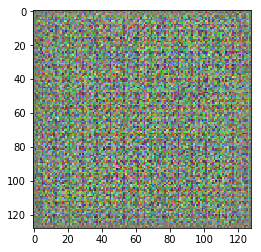

In [325]:
#generator = Generator()
generator = Generator1()

noise = tf.random.normal([1, 3, 128, 128])

i = image_ds_testA.take(1)
print("i:{}".format(list(i)))



gen_output = generator(noise, training=False)

gen_output = tf.transpose(gen_output, [0, 2, 3, 1])
print(gen_output.shape)

plt.imshow(gen_output[0,...])

# Discriminator

In [0]:
def Discriminator():
  debug_show_shapes = 0
  
  subDepth = 3
  df = "channels_first"

  inputs = tf.keras.Input(shape=(3, 128, 128))  # Returns a placeholder tensor
  if debug_show_shapes: print("inputs: {}".format(inputs.shape))
  
  l = layers.Conv2D(filters=NF*2, 
                        kernel_size=4, 
                        strides=2,
                        padding='same',
                        activation=tf.nn.relu, 
                        data_format=df, 
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"), 
                        use_bias=False)(inputs)
  
  if debug_show_shapes: print("l: {}".format(l.shape))
   
  #----
  
  relu1 = layers.Conv2D(filters=NF*4, 
                        kernel_size=4, 
                        strides=2,
                        padding='same',
                        activation=INLReLU, 
                        data_format=df, 
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"), 
                        use_bias=False)(l)
  
  if debug_show_shapes: print("relu1: {}".format(relu1.shape))
    
  #-----------------
    
  relu2 = layers.Conv2D(filters=NF*8, 
                        kernel_size=4, 
                        strides=2,
                        padding='same',
                        activation=INLReLU, 
                        data_format=df, 
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"), 
                        use_bias=False)(relu1)
  
  if debug_show_shapes: print("relu2: {}".format(relu2.shape))
    
  #-----------------
  
  relu3 = layers.Conv2D(filters=NF*8, 
                        kernel_size=3, 
                        strides=1,
                        padding='same',
                        activation=INLReLU, 
                        data_format=df, 
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"), 
                        use_bias=False)(relu2)
  
  if debug_show_shapes: print("relu3: {}".format(relu3.shape))
    
  #-----------------

  
  atrous = layers.Conv2D(filters=NF*8, 
                        kernel_size=3, 
                        strides=1,
                        padding='same',
                        activation=INLReLU, 
                        data_format=df, 
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"), 
                        use_bias=False,
                        dilation_rate=2,
                        bias_initializer=None)(relu3)
  ##INLReLU
  if debug_show_shapes: print("atrous: {}".format(atrous.shape))
    
  #-----------------
  
  atrous2 = layers.Conv2D(filters=NF*8, 
                        kernel_size=3, 
                        strides=1,
                        padding='same',
                        activation=INLReLU, 
                        data_format=df, 
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"), 
                        use_bias=False,
                        dilation_rate=4,
                        bias_initializer=None)(atrous)
  ##INLReLU
  if debug_show_shapes: print("atrous2: {}".format(atrous2.shape))
    
  #-----------------
  
  atrous3 = layers.Conv2D(filters=NF*8, 
                        kernel_size=3, 
                        strides=1,
                        padding='same',
                        activation=INLReLU, 
                        data_format=df, 
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"), 
                        use_bias=False,
                        dilation_rate=8,
                        bias_initializer=None)(atrous2)
  ##INLReLU
  if debug_show_shapes: print("atrous3: {}".format(atrous3.shape))
    
  #-----------------
  
  merge = tf.concat([relu3, atrous3], axis=1)
  if debug_show_shapes: print("merge: {}".format(merge.shape))
  #-----------------
  
  clean = layers.Conv2D(filters=NF*8, 
                        kernel_size=3, 
                        strides=1,
                        padding='same',
                        activation=INLReLU, 
                        data_format=df, 
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"), 
                        use_bias=False)(merge)
  
  if debug_show_shapes: print("clean: {}".format(clean.shape))
    
  #-----------------
  
  lsgan = layers.Conv2D(filters=1, 
                        kernel_size=3, 
                        strides=1,
                        padding='same',
                        activation=tf.identity, 
                        data_format=df, 
                        kernel_initializer=tf.initializers.VarianceScaling(scale=0.333, distribution="uniform"), 
                        use_bias=False)(clean)
  
  if debug_show_shapes: print("lsgan: {}".format(lsgan.shape))
    
  #-----------------
  
  model = tf.keras.Model(inputs=inputs, outputs=[lsgan, [relu1, relu2, relu3, atrous, atrous2, atrous3, clean]] )
  
  if debug_show_shapes: model.summary()

  return model  #whats with the other outputs

(1, 1, 16, 16)
(1, 16, 16, 1)


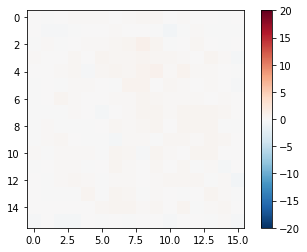

In [327]:
discriminator = Discriminator()

noise = tf.random.normal([1, 3, 128, 128])

disc_out,a = discriminator([noise, gen_output], training=False)

print(disc_out.shape)
disc_out = tf.transpose(disc_out, [0, 2, 3, 1])
print(disc_out.shape)

#plt.imshow(disc_out[0,...])


plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

# losses

In [0]:
def get_feature_match_loss(feats_real, feats_fake):
  print("gfml-1")
  #print(feats_fake)
  losses = []
  for real, fake in zip(feats_real, feats_fake):
      loss = tf.reduce_mean(tf.math.squared_difference(
          tf.reduce_mean(real, 0),
          tf.reduce_mean(fake, 0)),
          name='mse_feat_' + real.op.name)
      losses.append(loss)
  ret = tf.reduce_mean(losses, name='feature_match_loss')
  #add_moving_summary(ret)
  return ret

In [0]:
def loss_normalize(loss, update_condition, epsilon=1e-10):
  # Variable used for storing the scalar-value of the loss-function.
  loss_value = tf.Variable(1.0, name='loss_scalar_val_' + loss.op.name,
          trainable=False)

  loss_value_smooth = (tf.Variable(1.0, name='loss_smooth_' +
          loss.op.name, trainable=False))

  #TODO don't update if is_training
  ma_loss_value = (
      moving_averages.assign_moving_average(
              loss_value_smooth, loss, 0.9999, zero_debias=False, name='loss_EMA'
          )
      )

  #tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, ma_loss_value)
  # Expression used for either updating the scalar-value or
  # just re-using the old value.
  # Note that when loss_value.assign(loss) is evaluated, it
  # first evaluates the loss-function which is a TensorFlow
  # expression, and then assigns the resulting scalar-value to
  # the loss_value variable.
  print(update_condition)
  print(ma_loss_value)
  print(loss_value)
  loss_value_updated = tf.cond(update_condition,
                               lambda: loss_value.assign(ma_loss_value),
                               lambda: loss_value)


  # Expression for the normalized loss-function.
  loss_normalized = loss / (loss_value_updated + epsilon)

  #add_moving_summary(tf.identity(loss_value, name='loss_scalar_' + loss.op.name))

  return loss_normalized


In [0]:
def _tf_fspecial_gauss(size, sigma):
  """Function to mimic the 'fspecial' gaussian MATLAB function
  """
  x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

  x_data = np.expand_dims(x_data, axis=-1)
  x_data = np.expand_dims(x_data, axis=-1)

  y_data = np.expand_dims(y_data, axis=-1)
  y_data = np.expand_dims(y_data, axis=-1)

  x = tf.constant(x_data, dtype=tf.float32)
  y = tf.constant(y_data, dtype=tf.float32)

  g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
  return g / tf.reduce_sum(g)

In [0]:
def tf_ssim(img1, img2, cs_map=False, mean_metric=True, size=8, sigma=1.5):
  window = _tf_fspecial_gauss(size, sigma) # window shape [size, size]
  K1 = 0.03
  K2 = 0.05
  L = 1  # depth of image (255 in case the image has a differnt scale)
  C1 = (K1*L)**2
  C2 = (K2*L)**2
  mu1 = tf.nn.conv2d(img1, window, strides=[1,1,1,1], padding='VALID')
  mu2 = tf.nn.conv2d(img2, window, strides=[1,1,1,1], padding='VALID')
  mu1_sq = mu1*mu1
  mu2_sq = mu2*mu2
  mu1_mu2 = mu1*mu2
  sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1,1,1],padding='VALID') - mu1_sq
  sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1,1,1],padding='VALID') - mu2_sq
  sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1,1,1],padding='VALID') - mu1_mu2
  sigma1_sq = tf.abs(sigma1_sq)
  sigma2_sq = tf.abs(sigma2_sq)
  sigma12 = tf.abs(sigma12)
  if cs_map:

      value = (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                  (sigma1_sq + sigma2_sq + C2)),
              (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
  else:
      value = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                  (sigma1_sq + sigma2_sq + C2))

  if mean_metric:
      value = tf.reduce_mean(value)
  return value

In [0]:
def tf_ms_ssim(img1, img2, mean_metric=True, level=5):
  #From NCHW to NHWC
  img1 = tf.transpose(img1, [0, 2, 3, 1])
  img2 = tf.transpose(img2, [0, 2, 3, 1])

  weight = tf.constant([0.0448, 0.2856, 0.3001, 0.2363, 0.1333], dtype=tf.float32)
  mssim = []
  mcs = []
  for l in range(level):
      ssim_map, cs_map = tf_ssim(img1, img2, cs_map=True, mean_metric=False)
      mssim.append(tf.reduce_mean(ssim_map))
      mcs.append(tf.reduce_mean(cs_map))
      filtered_im1 = tf.nn.avg_pool(img1, [1,2,2,1], [1,2,2,1], padding='SAME')
      filtered_im2 = tf.nn.avg_pool(img2, [1,2,2,1], [1,2,2,1], padding='SAME')
      img1 = filtered_im1
      img2 = filtered_im2

  # list to tensor of dim D+1
  mssim = tf.stack(mssim, axis=0)
  mcs = tf.stack(mcs, axis=0)

  value = (tf.reduce_prod(mcs[0:level-1]**weight[0:level-1])*
                          (mssim[level-1]**weight[level-1]))

  if mean_metric:
      value = tf.reduce_mean(value)
  return value

In [0]:
def tf_dssim(img1, img2):
  img1 = tf.unstack(tf.expand_dims(img1, axis=2), axis=1)
  img2 = tf.unstack(tf.expand_dims(img2, axis=2), axis=1)
  value = tf.stack([tf_ms_ssim(i1, i2) for i1, i2 in zip(img1, img2)], axis=0)
  return tf.subtract(1.0, tf.reduce_sum(value)/3, name='DSSIM_loss')


In [0]:
def build_losses(logits_real, logits_fake):
  #Build standard GAN loss and set `self.g_loss` and `self.d_loss`.
  #D and G play two-player minimax game with value function V(G,D)
  #  min_G max _D V(D, G) = IE_{x ~ p_data} [log D(x)] + IE_{z ~ p_fake} [log (1 - D(G(z)))]
  #Args:
  #    logits_real (tf.Tensor): discrim logits from real samples
  #    logits_fake (tf.Tensor): discrim logits from fake samples produced by generator

  with tf.name_scope("GAN_loss"):
    score_real = tf.sigmoid(logits_real)
    score_fake = tf.sigmoid(logits_fake)
    #tf.summary.histogram('score-real', score_real)
    #tf.summary.histogram('score-fake', score_fake)

    with tf.name_scope("discrim"):
        d_loss_pos = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits_real, labels=tf.ones_like(logits_real)), name='loss_real')
        d_loss_neg = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits_fake, labels=tf.zeros_like(logits_fake)), name='loss_fake')

        d_pos_acc = tf.reduce_mean(tf.cast(score_real > 0.5, tf.float32), name='accuracy_real')
        d_neg_acc = tf.reduce_mean(tf.cast(score_fake < 0.5, tf.float32), name='accuracy_fake')

        d_accuracy = tf.add(.5 * d_pos_acc, .5 * d_neg_acc, name='accuracy')
        d_loss = tf.add(.5 * d_loss_pos, .5 * d_loss_neg, name='loss')

    with tf.name_scope("gen"):
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits_fake, labels=tf.ones_like(logits_fake)), name='loss')
        g_accuracy = tf.reduce_mean(tf.cast(score_fake > 0.5, tf.float32), name='accuracy')

    #add_moving_summary(g_loss, d_loss, d_accuracy, g_accuracy)
    
    return g_loss, d_loss, d_accuracy, g_accuracy

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  d_loss = tf.add(D_loss_A, D_loss_B, name='D_loss_total')
  
  return d_loss
  

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  
  g_loss = tf.add_n([
      (self.loss_normalize(G_loss_A + G_loss_B, loss_update) * 0.7 +
      self.loss_normalize(fm_loss_A + fm_loss_B, loss_update) * 0.3) * (1 - rate),
      (self.loss_normalize((recon_loss_A + recon_loss_B), loss_update) *
          0.7 +
  self.loss_normalize((recon_loss_A_l + recon_loss_B_l),
              loss_update) * 0.3) * rate], name='G_loss_total')
  
  return g_loss


# optimizers

In [0]:
#lr = tf.get_variable('learning_rate', initializer=2e-4,
#                 trainable=False)
#        return tf.train.AdamOptimizer(lr, beta1=0.5)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# training

In [0]:
def collect_variables(self, g_scope='gen', d_scope='discrim'):
  #"""
  #Assign `self.g_vars` to the parameters under scope `g_scope`,
  #and same with `self.d_vars`.
  #"""
  self.g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, g_scope)
  assert self.g_vars
  self.d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, d_scope)
  assert self.d_vars

In [0]:
@tf.function
def train_step(input_image, target):
#  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#    gen_output = generator(input_image, training=True)
#
#    disc_real_output = discriminator([input_image, target], training=True)
#    disc_generated_output = discriminator([input_image, gen_output], training=True)
#
#    gen_loss = generator_loss(disc_generated_output, gen_output, target)
#    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

#  generator_gradients = gen_tape.gradient(gen_loss,
#                                          generator.trainable_variables)
#  discriminator_gradients = disc_tape.gradient(disc_loss,
#                                               discriminator.trainable_variables)

#  generator_optimizer.apply_gradients(zip(generator_gradients,
#                                          generator.trainable_variables))
#  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
#                                              discriminator.trainable_variables))

  print("train step")
  
  A = input_image
  B = target
  
  print(A)
  print(B)
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    print("train step1")
    AB = generator(A, training=True)
    print("train step2")
    BA = generator(B, training=True)
    ABA = generator(AB, training=True)
    BAB = generator(BA, training=True)
    print("train step3")
    
    A_dis_real, A_feats_real = discriminator(A, training=True)
    print("train step4")
    A_dis_fake, A_feats_fake = discriminator(BA, training=True)
    print(A_feats_fake)
    B_dis_real, B_feats_real = discriminator(B, training=True)
    B_dis_fake, B_feats_fake = discriminator(AB, training=True)
    print("train step5")
  
    #------------
    recon_loss_A = tf_dssim(A, ABA)
    recon_loss_A_l = tf.losses.mean_absolute_error(A,ABA)  #@TODO what instead of MEAN

    print("train step6")
    # gan loss
    g_loss, d_loss, d_accuracy, g_accuracy = build_losses(A_dis_real, A_dis_fake)
    G_loss_A = g_loss
    D_loss_A = d_loss
    # feature matching loss
    print(A_feats_fake)
    fm_loss_A = get_feature_match_loss(A_feats_real, A_feats_fake)
    print("train step7")
    #-------------------
       
    recon_loss_B = tf_dssim(B, BAB)

    recon_loss_B_l = tf.losses.mean_absolute_error(B, BAB)
    print("train step8")

    g_loss, d_loss, d_accuracy, g_accuracy = build_losses(B_dis_real, B_dis_fake)
    G_loss_B = g_loss
    D_loss_B = d_loss# + grad_penalty_B
    fm_loss_B = get_feature_match_loss(B_feats_real, B_feats_fake)
    
    print("train step9")
    global_step = np.int64(1)   #get_global_step_var()
    rate = 0.01  #tf.train.piecewise_constant(global_step, [np.int64(15000), np.int64(25000), np.int64(50000), np.int64(100000)], [0.01, 0.10, 0.15, 0.20, 0.25])
    #rate = tf.identity(rate, name='rate')   # mitigate a TF bug
    loss_update = tf.logical_or(tf.equal(global_step, tf.constant(36,
        dtype=np.int64)), tf.equal(global_step % 90, tf.constant(0, dtype=np.int64)))
    print("train step9-1")
    rate = tf.constant(0.33, np.float32, name='static_rate')
    print("train step9-2")    
        
    g_loss = tf.add_n([
        (loss_normalize(G_loss_A + G_loss_B, loss_update) * 0.7 +
        loss_normalize(fm_loss_A + fm_loss_B, loss_update) * 0.3) * (1 - rate),
        (loss_normalize((recon_loss_A + recon_loss_B), loss_update) *
            0.7 +
    loss_normalize((recon_loss_A_l + recon_loss_B_l),
                loss_update) * 0.3) * rate], name='G_loss_total')
    
    print("train step10")
    d_loss = tf.add(D_loss_A, D_loss_B, name='D_loss_total')
    print("train step11")
    collect_variables('gen', 'discrim')

    self.g_loss = g_loss
    self.d_loss = d_loss

    add_moving_summary(recon_loss_A, recon_loss_B, rate, g_loss, d_loss,
            recon_loss_A_l, recon_loss_B_l)

In [0]:
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for input_image, target in dataset:
      train_step(input_image, target)

    clear_output(wait=True)
    for inp, tar in image_ds_testA_B.take(1):
      generate_images(generator, inp, tar)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [342]:
EPOCHS = 200
print(image_ds_trainA_B)
train(image_ds_trainA_B, EPOCHS)

<PrefetchDataset shapes: ((None, 3, 128, 128), (None, 3, 128, 128)), types: (tf.float32, tf.float32)>
train step
Tensor("input_image:0", shape=(1, 3, 128, 128), dtype=float32)
Tensor("target:0", shape=(1, 3, 128, 128), dtype=float32)
train step1
train step2
train step3
train step4
[<tf.Tensor 'model_21_1/conv2d_550/re_lu_31/Relu:0' shape=(1, 256, 32, 32) dtype=float32>, <tf.Tensor 'model_21_1/conv2d_551/re_lu_32/Relu:0' shape=(1, 512, 16, 16) dtype=float32>, <tf.Tensor 'model_21_1/conv2d_552/re_lu_33/Relu:0' shape=(1, 512, 16, 16) dtype=float32>, <tf.Tensor 'model_21_1/conv2d_553/re_lu_34/Relu:0' shape=(1, 512, 16, 16) dtype=float32>, <tf.Tensor 'model_21_1/conv2d_554/re_lu_35/Relu:0' shape=(1, 512, 16, 16) dtype=float32>, <tf.Tensor 'model_21_1/conv2d_555/re_lu_36/Relu:0' shape=(1, 512, 16, 16) dtype=float32>, <tf.Tensor 'model_21_1/conv2d_556/re_lu_37/Relu:0' shape=(1, 512, 16, 16) dtype=float32>]
train step5
train step6
[<tf.Tensor 'model_21_1/conv2d_550/re_lu_31/Relu:0' shape=(1, 2

ValueError: ignored